Requried Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import spacy

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import os

/home/vignesh/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
class SMSBase:
    
    nlp = spacy.load('en')
    
    def __init__(self, filename, frac=0.7):
        
        # details of the data
        self.filename = filename
        self.features = ['class', 'context']
        self.msg_df = pd.read_csv('../data/smsspam/SMSSpamCollection', sep='\t', names=self.features)
        
        # preprocessing on data
        self.format_context()
        self.extract_features()
        self.train_test_split(frac)
        
        
    def format_context(self):
        
        self.msg_df['context'] = self.msg_df['context'].map(lambda txt: txt.rstrip()) # removing white space at end
        self.msg_df['context'] = self.msg_df['context'].map(lambda txt: txt.replace(',', ' ,') if ',' in txt else txt)
        
        
    def extract_features(self):
        
        self.msg_df['len'] = self.msg_df['context'].str.len()
        self.msg_df['n_words'] = self.msg_df['context'].str.split().str.len()
        self.features = self.msg_df.columns
        
    
    def train_test_split(self, frac):
        
        self.train_msg = self.msg_df.sample(frac=frac)
        self.test_msg = self.msg_df.drop(self.train_msg.index)
        
    def create_lemmas(self, c):
        
        tokens = self.nlp(c)
        return [token.lemma_ for token in tokens]
    
    def create_tokens(self, c):
        
        tokens = self.nlp(c)
        return [token for token in tokens]
        
    
        

In [39]:
class Util:
    
    def report_classification(model, train_sms, test_sms, train_features, test_feature):
        
        train_cls = np.unique(train_sms[test_feature].values).tolist()
        test_cls = np.unique(test_sms[test_feature].values).tolist()
        
        assert(train_cls == test_cls)
        
        cls = train_cls
        
        x_train = train_sms[train_features].values.tolist()
        x_test = test_sms[train_features].values.tolist()
        y_train = train_sms[test_feature].values.tolist()
        y_test = test_sms[test_feature].values.tolist()
        
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)
        
        Util.evaluate(y_train, train_pred, y_test, test_pred, cls)
        
    
    def evaluate(y_train, train_pred, y_test, test_pred, cls):
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        cm_test = confusion_matrix(y_test, test_pred)
        cm_test_df = pd.DataFrame(cm_test, index=cls, columns=cls)
        ax = sns.heatmap(cm_test_df, annot=True, ax = axes[0], square=True)
        ax.set_title('test data pred')
        
        cm_train = confusion_matrix(y_train, train_pred)
        cm_train_df = pd.DataFrame(cm_train, index=cls, columns=cls)
        ax = sns.heatmap(cm_train_df, annot=True, ax=axes[1], square=True)
        ax.set_title('train data pred')
        
        print('-' * 20 + ' testing preformance ' + '-' * 20)
        print(classification_report(y_test, test_pred, target_names=cls))
        print('acc : ', metrics.accuracy_score(y_test, test_pred))
        
        print('-' * 20 + ' training preformace ' + '-' * 20)
        print(classification_report(y_train, train_pred, target_names=cls))
        print('acc : ', metrics.accuracy_score(y_train, train_pred))
        
    
    def plot_cdf(word_count, ax, deltax=None, xlog=False, xlim=[0, 1], deltay=0.25, ylog=False, ylim=[0, 1], xlabel='x'):
        
        df = pd.DataFrame(word_count, columns=[xlabel])
        display(df.describe())
        ecdf = sm.distributions.ECDF(word_count)
        x = ecdf.x
        y = ecdf.y
        assert len(x) == len(y)
        if deltax is not None:
            x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
            ax.set_xticks(x_ticks)
            
        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim[0], xlim[1])
        ax.vlines(np.mean(word_count), min(y), max(y), color='red', label='mean', linewidth=2)
        ax.vlines(np.median(word_count), min(y), max(y), color='orange', label='median', linewidth=2)
        ax.vlines(np.mean(word_count) + 2 * np.std(word_count), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
        ax.vlines(np.mean(word_count) + 3 * np.std(word_count), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)
        
        y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
        ax.set_ylabel('CDF')
        ax.set_yticks(y_ticks)
        ax.set_ylim(ylim[0], ylim[1])
        
        if xlog is True:
            ax.set_xscale('log')
            
        if ylog is True:
            ax.set_xscale('log')
            
        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.9)
        
        ax.legend(loc=4)
        
        sns.set_style('whitegrid')
        sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax=ax)
        
    def plot_class_dist(data, by):
        
        train_features = data.columns.drop(by)
        
        train_features = train_features[0]
        dist = data.groupby(by)[train_features].size() / len(data)
        display(dist)
        sns.barplot(x=dist.index, y=dist.values)
        
    
    def box_plot(data, by, y, ax):
        ax = sns.boxplot(x=by, y=y, data=data[[by, y]], ax=ax)
        ax.set_yscale('log')
        
    def dump_pickle(obj, filename):
        print('file_name : ' + filename)
        joblib.dump(obj, filename)
        
    def load_pickle(filename):
        return joblib.load(filename)
        
        

In [14]:
class SMSClassification(SMSBase):
    
    pipelines = {}
    params = {}
    model_file_name = '{}_model.pkl'
    
    def __init__(self, filename, frac=0.7):
        
        super().__init__(filename, frac)
        self.bow = CountVectorizer(analyzer=self.create_lemmas)
        self.tfidf = TfidfTransformer()
        self.svd = TruncatedSVD(n_components=50)
        self.cv = StratifiedKFold(n_splits=10)
        self.default_params = {
            'tfidf__use_idf': (True, False),
            'bow__analyzer': (self.create_lemmas, self.create_tokens)
        }
        self.X_train = self.train_msg['context'].values.tolist()
        self.y_train = self.train_msg['class'].values.tolist()
        self.X_test = self.test_msg['context'].values.tolist()
        self.y_test = self.test_msg['class'].values.tolist()
        
    def create_pipeline(self, option='NB'):
        
        if (option in self.pipelines) is False:
            
            if option is 'NB':
                classifier = MultinomialNB()
                pipeline = Pipeline([
                    ('bow', self.bow),
                    ('tfidf', self.tfidf),
                    ('classifier', classifier)
                ])
            
            elif option is 'SVM':
                classifier = SVC()
                pipeline = Pipeline([
                    ('bow', self.bow),
                    ('tfidf', self.tfidf),
                    ('svd', self.svd),
                    ('classifier', classifier)
                ])
                
            elif option is 'RFT':
                classifier = RandomForestClassifier()
                pipeline = Pipeline([
                    ('bow', self.bow),
                    ('tfidf', self.tfidf),
                    ('svd', self.svd),
                    ('classifier', classifier)
                ])
                
            else:
                classifier = MultinomialNB()
            
            self.pipelines[option] = pipeline
            return pipeline
        
        else:
            return self.pipelines[option]
        
    def create_grid_search_params(self, option='NB'):
        
        if (option in self.params) is False:
            
            if option is 'SVM':
                params = [
                    {
                        'classifier__C': [1, 10, 100, 1000],
                        'classifier__kernel': ['linear']
                    },
#                     {
#                         'classifier__C': [1, 10, 100, 1000],
#                         'classifier__gamma': [0.001, 0.0001],
#                         'classifier__kernel': ['rbf']
#                     }
                ]
            else:
                params = self.default_params
            
            self.params[option] = params
            
        else:
            params = self.params[option]
            
        return params
    
#     def validate(self, option='NB'):
        
#         pipeline = self.create_pipeline(option)
#         if pipeline is not None:
#             scores = cross_val_score(pipeline, self.X_train, self.y_train, scoring='accuracy', cv=self.cv, verbose=1)
#             print('scores = {}\nmean = {} std = {}'.format(scores, scores.mean(), scores.std()))
#         else:
#             print('pipelines does not exist')
            
    def train(self, option='NB', dump=True):
        
        print('training on train data')
        pipeline = self.create_pipeline(option)
        if pipeline is not None:
            params = self.create_grid_search_params(option)
            grid = GridSearchCV(pipeline, params, refit=True, n_jobs=1, scoring='accuracy', cv=self.cv)
            model = grid.fit(self.X_train, self.y_train)
            
            print('Grid search parameters : ')
            print(pd.DataFrame([model.best_params_]))
            
            if dump:
                model_file_name = self.model_file_name.format(option)
                Util.dump_pickle(model, model_file_name)
                
            return model
        else:
            print('pipeline does not exist')
            return None
        
    def test(self, X=None, model=None, model_file=None):
        
        if X is None:
            X = self.X_test
            
        if model is None and model_file is None:
            print('please use model or model file')
            return []
        
        if model_file is not None and os.path.isfile(model_file):
            model = Util.load_pickle(model_file)
            print('{} file was loaded'.format(model_file))
            return model.predict(X)
        
        if model is not None:
            return model.predict(X)
        
        else:
            return []
        
        

In [15]:
sms = SMSClassification('SMSSpam')

In [6]:
sms.msg_df.head()

,class,context,len,n_words
0,ham,"Go until jurong point , crazy.. Available only...",112,21
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf , he lives ar...",62,14


In [7]:
sms.msg_df.describe()

,len,n_words
count,5572.000000,5572.000000
mean,80.811917,15.947057
std,60.273482,11.747167
min,2.000000,1.000000
25%,36.000000,7.000000
50%,62.000000,13.000000
75%,123.000000,23.000000
max,910.000000,175.000000


In [8]:
sms.msg_df.groupby(by=['class']).describe()

len                                                           \
        count        mean        std   min    25%    50%    75%    max   
class                                                                    
ham    4825.0   71.775337  58.783939   2.0   33.0   52.0   93.0  910.0   
spam    747.0  139.180723  29.067007  13.0  133.0  149.0  158.0  224.0   

      n_words                                                      
        count       mean        std  min   25%   50%   75%    max  
class                                                              
ham    4825.0  14.628808  11.867236  1.0   7.0  11.0  19.0  175.0  
spam    747.0  24.461847   6.000633  2.0  22.0  26.0  28.0   37.0

class
ham     0.865937
spam    0.134063
Name: context, dtype: float64

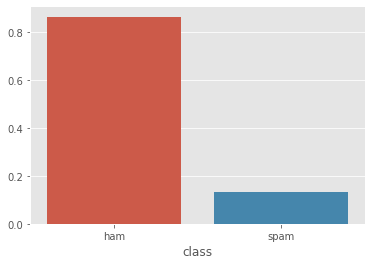

In [9]:
Util.plot_class_dist(sms.msg_df, 'class')

,number of words
count,5572.000000
mean,15.947057
std,11.747167
min,1.000000
25%,7.000000
50%,13.000000
75%,23.000000
max,175.000000


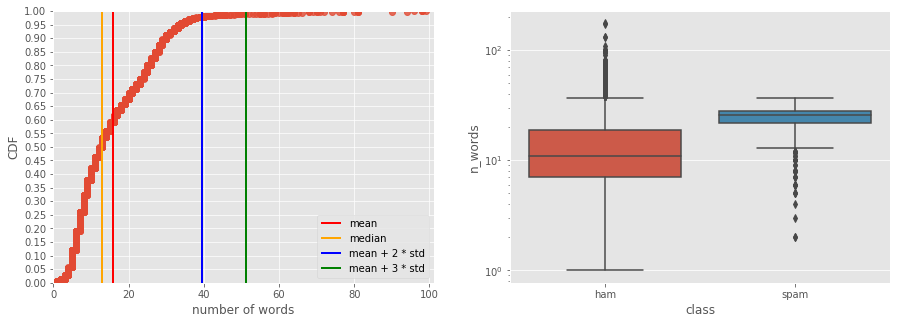

In [10]:
n_words = sms.msg_df['n_words'].values.tolist()

ecdf = sm.distributions.ECDF(n_words)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
Util.plot_cdf(n_words, 
              ax[0], 
              xlim = [0, np.mean(n_words) + 3 * np.std(n_words) + 50],
              deltay = 0.05,
              ylim = [0, 1.00],
              xlabel = 'number of words'
             )

Util.box_plot(sms.msg_df, 'class', 'n_words', ax[1])

,length of words
count,5572.000000
mean,80.811917
std,60.273482
min,2.000000
25%,36.000000
50%,62.000000
75%,123.000000
max,910.000000


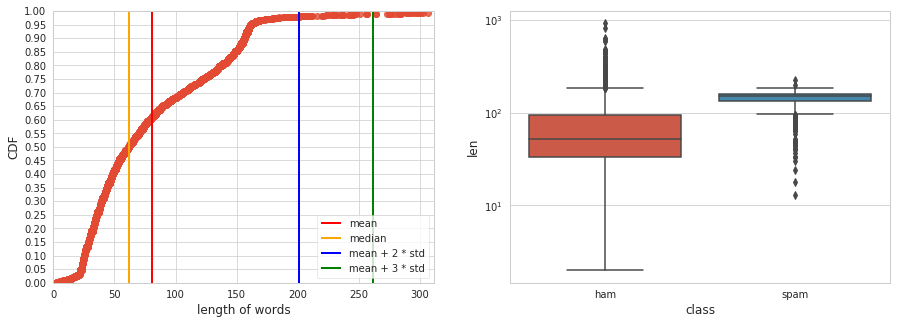

In [11]:
word_len = sms.msg_df['len'].values.tolist()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

Util.plot_cdf(
            word_len,
            ax[0],
            xlim = [0, np.mean(word_len) + 3 * np.std(word_len) + 50],
            deltay = 0.05,
            ylim = [0, 1.00], 
            xlabel = 'length of words'
        )

Util.box_plot(sms.msg_df, 'class', 'len', ax[1])

In [12]:
# The box plots of both number of words and legth of msg shows that spam and ham msgs have 
# uniquely identified distributions

In [9]:
# classification

classifiers = ['NB', 'SVM', 'RFT']

In [7]:
# for cls in classifiers:
#     print('-' * 30 + cls + '-' * 30)
#     %time sms.validate(cls)

------------------------------NB------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


scores = [0.95519713 0.95698925 0.93895871 0.95870736 0.95152603 0.95691203
 0.94614004 0.94614004 0.9551167  0.96409336]
mean = 0.9529780634865478 std = 0.006997187184336367
CPU times: user 10min 3s, sys: 89.6 ms, total: 10min 3s
Wall time: 10min 6s
------------------------------SVM------------------------------


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


scores = [0.98566308 0.98566308 0.98384201 0.98025135 0.98025135 0.97486535
 0.97127469 0.97307002 0.97486535 0.98922801]
mean = 0.979897427977581 std = 0.005839215073824112
CPU times: user 10min 7s, sys: 7.12 s, total: 10min 14s
Wall time: 10min 5s
------------------------------RFT------------------------------
scores = [0.96415771 0.98028674 0.96947935 0.96409336 0.97307002 0.96050269
 0.96588869 0.96588869 0.97127469 0.98384201]
mean = 0.9698483941751446 std = 0.007081911662083501
CPU times: user 10min 32s, sys: 6.99 s, total: 10min 39s
Wall time: 10min 35s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.6min finished


In [10]:
# choosing hyper parameters using GridSearchCV

models = {}

classifiers = ['NB', 'SVM', 'RFT']
for cls in classifiers:
    print('-' * 30 + cls + '-' * 30)
    %time models[cls] = sms.train(cls)

------------------------------NB------------------------------
training on train data
Grid search parameters : 
                                       bow__analyzer  tfidf__use_idf
0  <bound method SMSBase.create_lemmas of <__main...            True
file_name : NB_model.pkl
CPU times: user 28min 35s, sys: 589 ms, total: 28min 35s
Wall time: 28min 52s
------------------------------SVM------------------------------
training on train data
Grid search parameters : 
   classifier__C classifier__kernel
0            100             linear
file_name : SVM_model.pkl
CPU times: user 29min 22s, sys: 21.7 s, total: 29min 44s
Wall time: 29min 20s
------------------------------RFT------------------------------
training on train data
Grid search parameters : 
                                       bow__analyzer  tfidf__use_idf
0  <bound method SMSBase.create_lemmas of <__main...            True
file_name : RFT_model.pkl
CPU times: user 31min 55s, sys: 54 s, total: 32min 49s
Wall time: 31min 11s


------------------------------NB------------------------------
-------------------- testing preformance --------------------
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1440
        spam       1.00      0.70      0.82       232

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672

acc :  0.9581339712918661
-------------------- training preformace --------------------
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      3385
        spam       1.00      0.68      0.81       515

    accuracy                           0.96      3900
   macro avg       0.98      0.84      0.89      3900
weighted avg       0.96      0.96      0.95      3900

acc :  0.9574358974358974
------------------------------SVM------------------------------
-------------------- testing preformance --

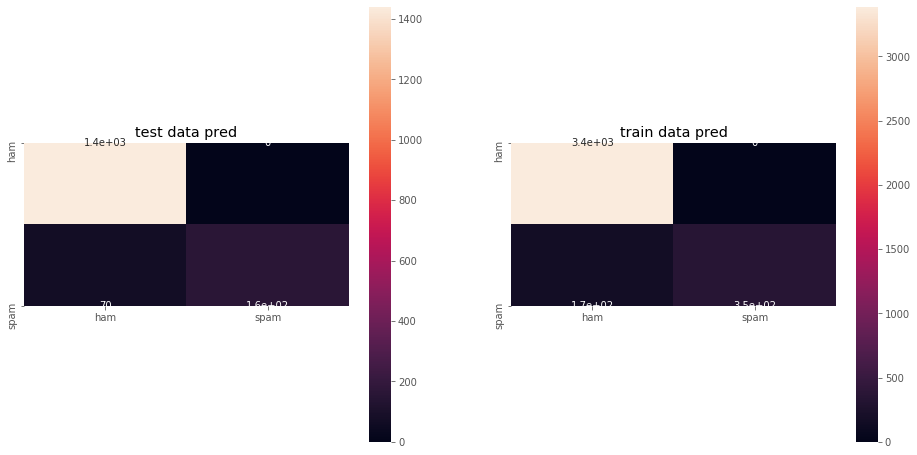

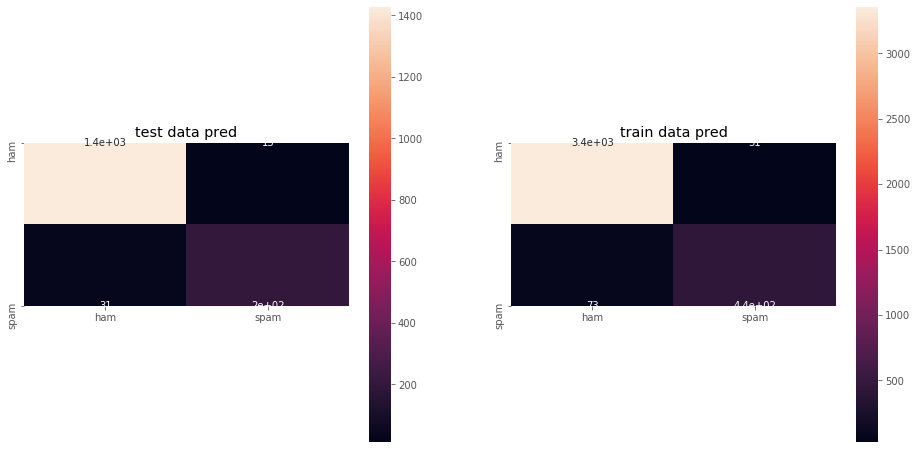

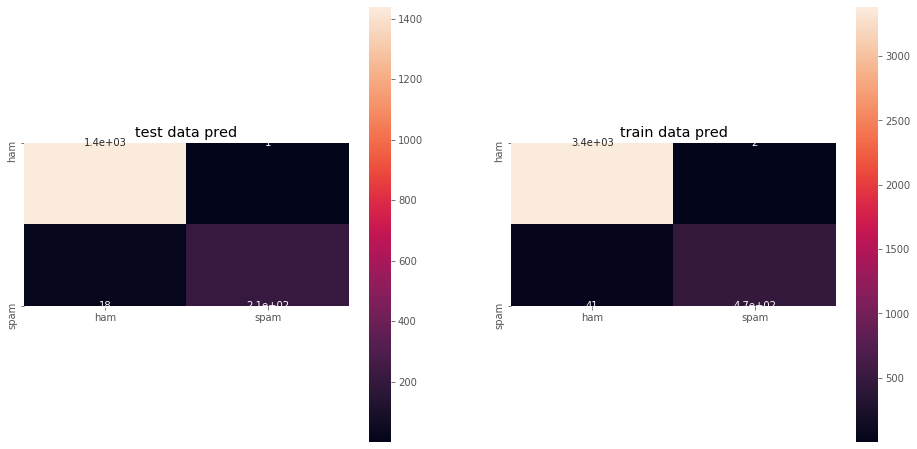

In [40]:
for cls in classifiers:
    print('-' * 30 + cls + '-' * 30)
    model_file = '{}_model.pkl'.format(cls)
    model = Util.load_pickle(model_file)
    Util.report_classification(model, sms.train_msg, sms.test_msg, 'context', 'class')